In [2]:
# %%
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from collections import Counter
from functools import reduce

#For interactive plots 

import plotly.graph_objects as go #pip install plotly
import dash
from dash import dcc, html #pip install dash
from dash.dependencies import Input, Output #pip install dash-bootstrap-components

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

from src.data.utils import get_franchise_movies, get_franchise_data, get_inflation_rate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading and processing 


In [3]:
#loading the complete data set 
movies_df = pd.read_csv('data/movie_metadata_with_tmdb.csv')

#loading the data set for the franchise movies 
inflation_rate_df=get_inflation_rate()
franchise_df=get_franchise_movies(movies_df,inflation_rate_df)

#Data frame with movies that are not part of a franchise
movies_no_franchise = movies_df.copy()[movies_df['collection_id'].isna()]
# CREER DANS UTILS UNE FONCTION POUR AVOIR LES MEME COLONNES POUR LES FILMS PAS DANS DES FRANCHISES 

## Data presentation 

### General numerical analysis 


In [4]:
# Counting the number of movies per collections
franchise_counts = franchise_df.groupby(by='collection_id')['Wikipedia movie ID'].count()
print(franchise_counts.describe())
print(f"Number of movies in collections: {len(franchise_df['collection_id'])}")
print(f"Number of movies in the entire data set: {len(movies_df['collection_id'])}")
print(f"Number of movies not in a collections: {len(movies_no_franchise)}")


count    1595.000000
mean        3.243260
std         3.751337
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        66.000000
Name: Wikipedia movie ID, dtype: float64
Number of movies in collections: 5173
Number of movies in the entire data set: 81740
Number of movies not in a collections: 75558


When importing the data, we decided to directly drop the franchises that had only one movie, as it would bias our analysis (it means that the other movies in the collections were not included in the dataset as they were released after 2016). 
Now, we have 1595 collections, with 5173 movies, which we deem enough. We also see a strong outlier that has 66 movies (the maximum).


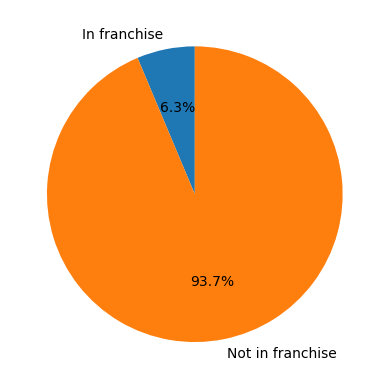

In [5]:
proportion = len(franchise_df) / len(movies_df)
proportions = pd.DataFrame({'Proportion': [proportion, 1 - proportion]}, index=['In franchise', 'Not in franchise'])
explode = (0, 0.1)
fig, ax = plt.subplots()
ax.pie(proportions['Proportion'], labels=proportions.index, autopct='%1.1f%%', startangle=90)

plt.show()

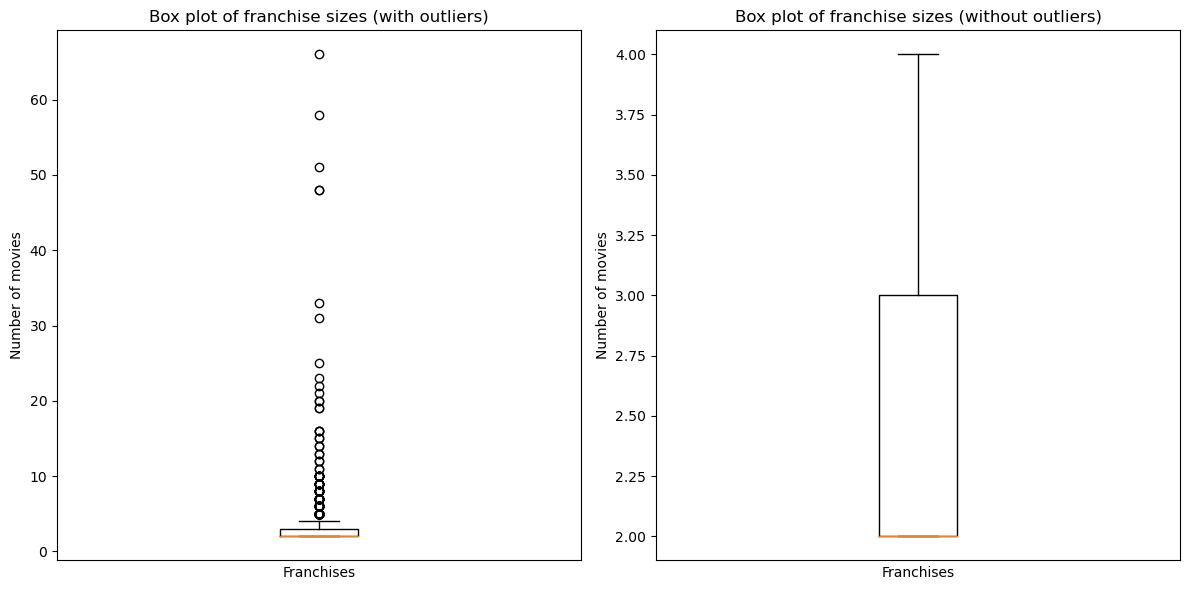

In [6]:
# Plot the box plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot with outliers
axes[0].boxplot(franchise_counts)
axes[0].set_title('Box plot of franchise sizes (with outliers)')
axes[0].set_ylabel('Number of movies')
axes[0].set_xlabel('Franchises')
axes[0].set_xticks([])

# Boxplot without outliers
axes[1].boxplot(franchise_counts, showfliers=False)
axes[1].set_title('Box plot of franchise sizes (without outliers)')
axes[1].set_ylabel('Number of movies')
axes[1].set_xlabel('Franchises')
axes[1].set_xticks([])

plt.tight_layout()
plt.show()

Here, we can see that at least 75% of the franchises have between 2 and 4 movies. And when looking closely at the outliers, such as "Our gang: The Roach/Pathé silents (1922-1928)" with 66 movies, we see that they mostly do not correspond to sequels, but to franchises. This is something to keep in mind for the data analysis.

# Univariate Analysis 

## Box office 

In [11]:

franchise_revenue = franchise_df.dropna(subset=['real_revenue'])
movies_revenue = movies_df.dropna(subset=['revenue']) #DO THE REAL 
movies_no_franchise_revenue = movies_no_franchise.dropna(subset=['revenue'])
print(franchise_df['collection_id'].value_counts()) # This indicates that for all franhcise we have at leats 2 movies 

collection_id
564261.0     66
563999.0     58
392686.0     51
415931.0     48
435347.0     48
             ..
131635.0      2
186102.0      2
205145.0      2
263106.0      2
1051260.0     2
Name: count, Length: 1595, dtype: int64


       non-franchise movies  franchise movies    all movies
count          6.372400e+04      1.257000e+03  6.990600e+04
mean           3.723149e+06      8.102463e+08  6.484140e+06
std            2.619021e+07      1.308956e+09  4.554371e+07
min            0.000000e+00      7.258898e+04  0.000000e+00
25%            0.000000e+00      8.395728e+07  0.000000e+00
50%            0.000000e+00      2.908048e+08  0.000000e+00
75%            0.000000e+00      9.615837e+08  0.000000e+00
max            2.264162e+09      1.773935e+10  2.923706e+09


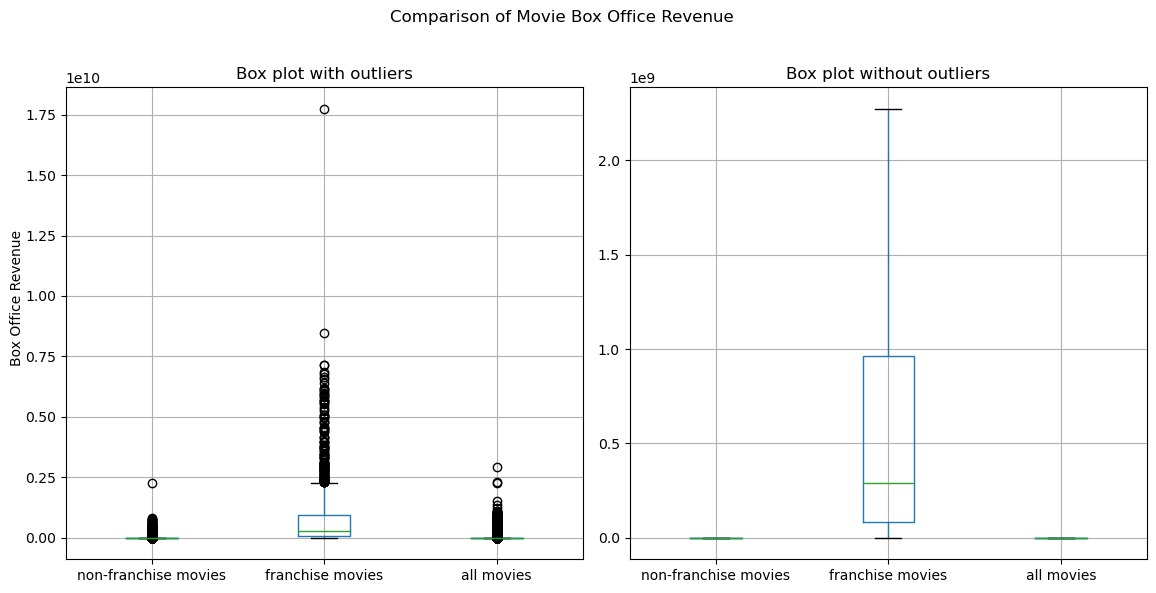

In [13]:
all_box= pd.DataFrame({
        'non-franchise movies': movies_no_franchise_revenue['revenue'], #movie_box['Movie box office revenue'],
        'franchise movies': franchise_revenue['real_revenue'], # box_office_df['Movie box office revenue']
        'all movies': movies_revenue['revenue']
        })
print(all_box.describe())
#Box plot to compare Movie box office in film that are in franchise and those that are not
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
# Plot with outliers
all_box.boxplot(ax=axes[0])
axes[0].set_title('Box plot with outliers')
    
# Plot without outliers
all_box.boxplot(ax=axes[1], showfliers=False)
axes[1].set_title('Box plot without outliers')
    
fig.text(0.04, 0.5, 'Box Office Revenue', va='center', rotation='vertical')
plt.suptitle('Comparison of Movie Box Office Revenue')
plt.tight_layout(rect=[0.04, 0, 1, 0.96])
plt.show()